# Spacial distribution / anonymization

## Imports and config

In [40]:
import io
import math
import os

import folium
import geojson
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

In [41]:
# Change directory to scripts folder
directory = os.getcwd().split('/')[-1]

if directory == 'notebooks':
    %cd ..

In [42]:
# Matplotlib setup
import matplotlib

# matplotlib.use('PDF')

import matplotlib.pyplot as plt
print(f'matplotlib backend: {matplotlib.get_backend()}')

matplotlib backend: module://matplotlib_inline.backend_inline


In [43]:
# configuration variables
should_save = False

## Load

In [44]:
incidents = pd.read_csv('proprietary_data/cleaned_data.csv')
incidents = incidents.drop(columns=['geometry'])
incidents_columns = incidents.columns
incidents

/tmp/ipykernel_16224/379880763.py:1: DtypeWarning: Columns (8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents = pd.read_csv('proprietary_data/cleaned_data.csv')


,id,hastegrad,tidspunkt,tiltak_opprettet,ressurs_id,tiltak_type,varslet,rykker_ut,ank_hentested,avg_hentested,...,rsize,col,row,xcoor,ycoor,popTot,popAve,popFem,popMal,statistikkÅr
0,1,A,2015-02-13 09:23:18,2015-02-13 09:29:23,119 Legebil,Legebil,2015-02-13 09:29:28,2015-02-13 09:29:33,NaN,NaN,...,1000,213,371,264500,6631500,102,37.7,58,44,2016
1,2,A,2015-02-13 14:01:29,2015-02-13 14:02:53,201,Ambulanse,2015-02-13 14:04:42,2015-02-13 14:04:47,NaN,2015-02-13 14:26:23,...,1000,223,349,242500,6641500,1329,38.1,692,637,2016
2,3,V1,2015-02-13 13:35:14,2015-02-13 13:40:36,261,Ambulanse,2015-02-13 13:46:07,2015-02-13 13:47:57,NaN,NaN,...,1000,222,372,265500,6640500,1540,36.7,770,770,2016
3,4,H,2015-02-13 05:09:00,2015-02-13 05:11:02,242,Ambulanse,2015-02-13 05:14:07,2015-02-13 05:16:54,NaN,2015-02-13 05:41:41,...,1000,234,371,264500,6652500,6153,34.5,3103,3050,2016
4,5,V1,2015-02-13 16:00:39,2015-02-13 16:00:41,281,Ambulanse,2015-02-13 16:00:55,2015-02-13 16:01:13,NaN,NaN,...,1000,203,360,253500,6621500,592,48.6,307,285,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754806,814663,V1,2016-12-14 11:00:00,2016-11-01 11:24:51,323,Ambulanse,2016-12-14 11:07:16,2016-12-14 11:08:45,2016-12-14 11:18:45,2016-12-14 11:31:32,...,1000,152,376,269500,6570500,2046,43.7,1086,960,2016
754807,814664,V2,2017-12-15 09:00:00,2017-10-31 09:39:45,142,Ambulanse,2017-12-15 09:09:03,2017-12-15 09:23:26,2017-12-15 09:29:33,2017-12-15 09:46:31,...,1000,253,412,305500,6671500,107,43.6,51,56,2016
754808,814665,V2,2016-11-03 08:00:00,2016-09-14 15:15:29,351,Ambulanse,2016-11-03 08:07:45,2016-11-03 08:12:50,2016-11-03 08:24:09,2016-11-03 08:41:02,...,1000,193,390,283500,6611500,1715,48.4,922,793,2016
754809,814666,V2,2017-10-18 07:00:00,2017-10-18 07:33:13,262,Ambulanse,2017-10-18 08:09:06,2017-10-18 08:09:45,2017-10-18 08:32:07,2017-10-18 08:52:31,...,1000,227,375,268500,6645500,768,39.8,416,352,2016


## Filter out cells outside of Oslo and Akershus

In [45]:
oslo = pd.read_csv('data/oslo.csv', encoding='utf-8', index_col=4)
akershus = pd.read_csv('data/akershus.csv', encoding='utf-8', index_col=4)
oslo_and_akershus_data = pd.concat([oslo, akershus])

# Create indices based on SSB grids
oslo_and_akershus = oslo_and_akershus_data.index
incidents_cells = pd.Index(incidents['ssbid1000M'])

# Print useful stats
print('Oslo and Akershus cell count:', oslo_and_akershus.shape[0])
print('Total cell count in dataset:', incidents_cells.unique().shape[0])
print('Cells in dataset in Oslo and Akershus:', incidents_cells.unique().isin(oslo_and_akershus).sum())
print('Empty cells in Oslo and Akershus:', oslo_and_akershus.shape[0] - incidents_cells.unique().isin(oslo_and_akershus).sum())

initial_row_count = incidents.shape[0]
print('Initial row count:', initial_row_count)

# Filter out all incident cells that are not located in Oslo and Akershus
incidents = incidents[incidents_cells.isin(oslo_and_akershus)]

rows_remaining = incidents.shape[0]
print(f'Rows remaining: {rows_remaining}')

rows_removed = initial_row_count - rows_remaining
print(f'Rows removed: {rows_removed}')

Oslo and Akershus cell count: 5569
Total cell count in dataset: 5089
Cells in dataset in Oslo and Akershus: 2606
Empty cells in Oslo and Akershus: 2963
Initial row count: 754811
Rows remaining: 585374
Rows removed: 169437


In [46]:
spacial = incidents[['xcoor', 'ycoor', 'ssbid1000M']]
spacial

,xcoor,ycoor,ssbid1000M
0,264500,6631500,22640006631000
1,242500,6641500,22420006641000
2,265500,6640500,22650006640000
3,264500,6652500,22640006652000
4,253500,6621500,22530006621000
...,...,...,...
754801,264500,6643500,22640006643000
754805,269500,6652500,22690006652000
754807,305500,6671500,23050006671000
754809,268500,6645500,22680006645000


## Create distribution and resample data

In [47]:
distribution = spacial['ssbid1000M'].value_counts() / len(spacial)
print(f'Sum: {distribution.sum()}')
distribution

Sum: 1.0


22620006649000    0.085200
22760006650000    0.029545
22600006653000    0.026207
22480006648000    0.018057
22620006651000    0.016760
                    ...   
22880006679000    0.000002
23000006631000    0.000002
22690006617000    0.000002
23060006624000    0.000002
22610006632000    0.000002
Name: ssbid1000M, Length: 2606, dtype: float64

In [48]:
spacial['ssbid1000M'].value_counts()

22620006649000    49874
22760006650000    17295
22600006653000    15341
22480006648000    10570
22620006651000     9811
                  ...  
22880006679000        1
23000006631000        1
22690006617000        1
23060006624000        1
22610006632000        1
Name: ssbid1000M, Length: 2606, dtype: int64

In [49]:
resampled = np.random.choice(distribution.index, p=distribution, size=len(spacial))
resampled = pd.Series(resampled, name='ssbid1000M')
resampled_distribution = resampled.value_counts() / len(resampled)
print(f'Sum: {resampled_distribution.sum()}')
resampled_distribution

Sum: 1.0000000000000002


22620006649000    0.085771
22760006650000    0.029585
22600006653000    0.026255
22480006648000    0.017713
22620006651000    0.016586
                    ...   
23040006635000    0.000002
23000006626000    0.000002
22810006667000    0.000002
23020006678000    0.000002
22960006656000    0.000002
Name: ssbid1000M, Length: 2512, dtype: float64

In [50]:
# Add missing IDs with zero probability to match length
missing_ids = distribution.index.difference(resampled_distribution.index)
resampled_distribution = pd.concat([resampled_distribution, pd.Series(0.0, index=missing_ids)])
resampled_distribution

22620006649000    0.085771
22760006650000    0.029585
22600006653000    0.026255
22480006648000    0.017713
22620006651000    0.016586
                    ...   
23140006635000    0.000000
23140006641000    0.000000
23180006640000    0.000000
23190006658000    0.000000
23210006639000    0.000000
Length: 2606, dtype: float64

In [51]:
print(f'Unique IDs in original data set: {len(distribution.index.unique())}')
print(f'Unique IDs in resampled data set: {len(resampled_distribution.index.unique())}')

Unique IDs in original data set: 2606
Unique IDs in resampled data set: 2606


### Check similarity of distributions

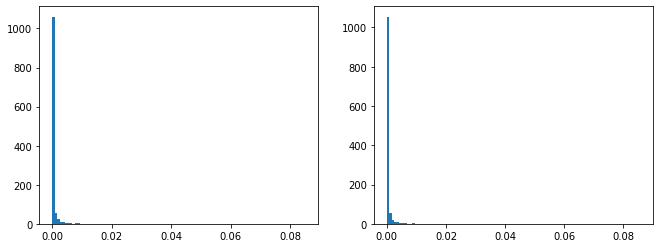

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
ax1.hist(distribution, bins=100, density=True)
ax2.hist(resampled_distribution, bins=100, density=True);

In [53]:
# Information entropy
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [54]:
kl_divergence(resampled_distribution.values, distribution.values)

/tmp/ipykernel_16224/4038897584.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
/tmp/ipykernel_16224/4038897584.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


0.00032133361954036046

### Join resampled with incidents 

In [55]:
spacial_lookup = spacial.drop_duplicates().set_index('ssbid1000M')
spacial_lookup

,xcoor,ycoor
ssbid1000M,,
22640006631000,264500,6631500
22420006641000,242500,6641500
22650006640000,265500,6640500
22640006652000,264500,6652500
22530006621000,253500,6621500
...,...,...
23210006639000,321500,6639500
22940006659000,294500,6659500
23020006672000,302500,6672500


In [56]:
resampled_spacial = pd.merge(resampled, spacial_lookup, on='ssbid1000M')
resampled_spacial = resampled_spacial[spacial.columns]
resampled_spacial

,xcoor,ycoor,ssbid1000M
0,276500,6650500,22760006650000
1,276500,6650500,22760006650000
2,276500,6650500,22760006650000
3,276500,6650500,22760006650000
4,276500,6650500,22760006650000
...,...,...,...
585369,277500,6682500,22770006682000
585370,305500,6685500,23050006685000
585371,296500,6688500,22960006688000
585372,271500,6707500,22710006707000


In [57]:
len(incidents)

585374

In [58]:
anonymized_incidents = incidents.drop(resampled_spacial.columns, axis=1)
anonymized_incidents = pd.concat([anonymized_incidents.reset_index(), resampled_spacial], axis=1)
anonymized_incidents = anonymized_incidents[incidents_columns]
anonymized_incidents

,id,hastegrad,tidspunkt,tiltak_opprettet,ressurs_id,tiltak_type,varslet,rykker_ut,ank_hentested,avg_hentested,...,rsize,col,row,xcoor,ycoor,popTot,popAve,popFem,popMal,statistikkÅr
0,1,A,2015-02-13 09:23:18,2015-02-13 09:29:23,119 Legebil,Legebil,2015-02-13 09:29:28,2015-02-13 09:29:33,NaN,NaN,...,1000,213,371,276500,6650500,102,37.7,58,44,2016
1,2,A,2015-02-13 14:01:29,2015-02-13 14:02:53,201,Ambulanse,2015-02-13 14:04:42,2015-02-13 14:04:47,NaN,2015-02-13 14:26:23,...,1000,223,349,276500,6650500,1329,38.1,692,637,2016
2,3,V1,2015-02-13 13:35:14,2015-02-13 13:40:36,261,Ambulanse,2015-02-13 13:46:07,2015-02-13 13:47:57,NaN,NaN,...,1000,222,372,276500,6650500,1540,36.7,770,770,2016
3,4,H,2015-02-13 05:09:00,2015-02-13 05:11:02,242,Ambulanse,2015-02-13 05:14:07,2015-02-13 05:16:54,NaN,2015-02-13 05:41:41,...,1000,234,371,276500,6650500,6153,34.5,3103,3050,2016
4,5,V1,2015-02-13 16:00:39,2015-02-13 16:00:41,281,Ambulanse,2015-02-13 16:00:55,2015-02-13 16:01:13,NaN,NaN,...,1000,203,360,276500,6650500,592,48.6,307,285,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585369,814658,V2,2015-11-02 08:00:00,2015-10-02 13:52:31,263,Ambulanse,2015-11-02 08:19:16,2015-11-02 08:20:52,2015-11-02 08:36:31,2015-11-02 08:52:05,...,1000,225,371,277500,6682500,3200,41.0,1634,1566,2016
585370,814662,V2,2017-09-27 10:15:00,2017-08-18 11:37:57,234,Ambulanse,2017-09-27 11:32:29,2017-09-27 11:38:07,2017-09-27 11:57:04,NaN,...,1000,234,376,305500,6685500,1410,38.3,771,639,2016
585371,814664,V2,2017-12-15 09:00:00,2017-10-31 09:39:45,142,Ambulanse,2017-12-15 09:09:03,2017-12-15 09:23:26,2017-12-15 09:29:33,2017-12-15 09:46:31,...,1000,253,412,296500,6688500,107,43.6,51,56,2016
585372,814666,V2,2017-10-18 07:00:00,2017-10-18 07:33:13,262,Ambulanse,2017-10-18 08:09:06,2017-10-18 08:09:45,2017-10-18 08:32:07,2017-10-18 08:52:31,...,1000,227,375,271500,6707500,768,39.8,416,352,2016


In [60]:
anonymized_incidents.to_csv('proprietary_data/anonymized_data.csv', index=False)